In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D, Leakytanh, UpSampling2D, BatchNormalization, Concatenate, Input
from keras.layers import *
from tensorflow.keras.optimizers import *


df = pd.read_csv('/content/drive/MyDrive/LaneProject/label_data_0531.csv')
h = 16*20
w = 32*20
#45 is limit
ratio = 720/h

x=[]
l0 = []
l1 = []
new_paths = []
x_v = []
y_v = []
X=[]
Y=[]
coef_matrix=[]
X_mask=[]
orig=[]

order = 2

paths = df.iloc[:,-1].values
lane0 = df.iloc[:,df.columns.str.startswith('lanes/0')].values
lane1 = df.iloc[:,df.columns.str.startswith('lanes/1')].values
lane2 = df.iloc[:,df.columns.str.startswith('lanes/2')].values
lane3 = df.iloc[:,df.columns.str.startswith('lanes/3')].values
lane4 = df.iloc[:,df.columns.str.startswith('lanes/4')].values
h_sample = df.iloc[:,df.columns.str.startswith('h_sample')].values

h_sample = h_sample/ratio

In [14]:
no_lane = 2
lane = np.concatenate((lane0,lane1), axis=1)
lane = np.resize(lane, (358,no_lane,56))

# LOADING IMAGES IN A NUMPY ARRAY

train_img = np.array([1,2,3,4])
#/content/drive/MyDrive/LaneProject/clips
for j in train_img:
    p = paths[j]
    print(j)
    p = '/content/drive/MyDrive/LaneProject/' + p
    #p = "/content/drive/MyDrive/LaneProject/clips/0531/1492626270684175793/1.jpg"
    image = cv2.imread(p)
    print(p)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    orig.append(image)
    image = np.resize(image, (h,w))
    #image = image[160:320,:]
    x.append(image)
x = np.array(x)
orig = np.array(orig)

1
/content/drive/MyDrive/LaneProject/clips/0531/1492626371522989086/20.jpg
2
/content/drive/MyDrive/LaneProject/clips/0531/1492626395742137012/20.jpg
3
/content/drive/MyDrive/LaneProject/clips/0531/1492626551883775328/20.jpg
4
/content/drive/MyDrive/LaneProject/clips/0531/1492626688464435547/20.jpg


In [15]:
for i in range(len(lane)):
    for j in range(len(lane[0])):
        for k in range(56):
            if(lane[i,j,k]!=-2 and np.isnan(lane[i,j,k]) == False):
                x_v.append(int(lane[i,j,k]/ratio))
                y_v.append(h_sample[i,k])
        X = np.array(x_v)
        Y = np.array(y_v)
        x_v.clear()
        y_v.clear()

        if(len(X) == 0):
            coef = np.zeros((order+1))
        else:
            coef = np.polyfit(Y,X,order)
        coef_matrix.append(coef)
        solver = np.poly1d(coef)
        y_range = np.linspace(0,h-1, num=h)
        x_pred = solver(y_range)
        X_mask.append(x_pred)

coef_matrix = np.array(coef_matrix)
coef_matrix = np.resize(coef_matrix,(len(lane), len(lane[1]),order+1))
X_mask = np.array(X_mask)
X_mask = np.reshape(X_mask, (358,no_lane,h))
#X_mask = np.reshape(X_mask, (358,4,551))
X_mask = X_mask.astype(int)

In [16]:
#print(len(lane))
#y_segment.shape
print(len(X_mask[1]))
#X_mask.shape
#np.linspace(0,w-1,num=w)

#for k in range (x.shape[0]):
  #for i in range (x.shape[1]):
    #for j in range (x.shape[2]):
      #if (i < 150):
        #x[k][i][j] = 0

2


In [17]:
y_segment = np.zeros(x.shape)

#print(len(X_mask[1]))

#PUTTING 255 WHERE NEEDED ON MASK
for i in range(len(x)):
    for j in range(len(X_mask[1])):
        for k in range(160,320):
            #row_val = int(y_range[k])
            a = X_mask[i,j,k]
            #print(i,j,k,a)
            if(a>0 and a<w):
                y_segment[i,k,a] = 1
                #print('True')
                #print(y_segment[i,row_val,a])

In [18]:
for k in range(y_segment.shape[0]):
    for i in range(y_segment.shape[1]):
        min=w-1
        max=w
        for j in range(y_segment.shape[2]):
            if(y_segment[k][i][j]==1 and j < min):
              min = j
            elif(y_segment[k][i][j]==1):
              max = j
        if(max==w and min!=w-1):
            max = min
            min = 0
        for j in range(y_segment.shape[2]):
          if(j > min and j < max):
            y_segment[k][i][j] = 1


0


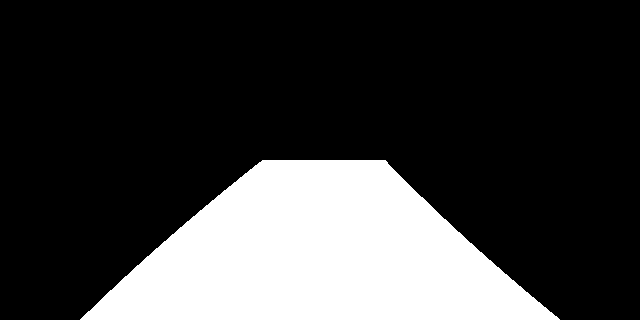

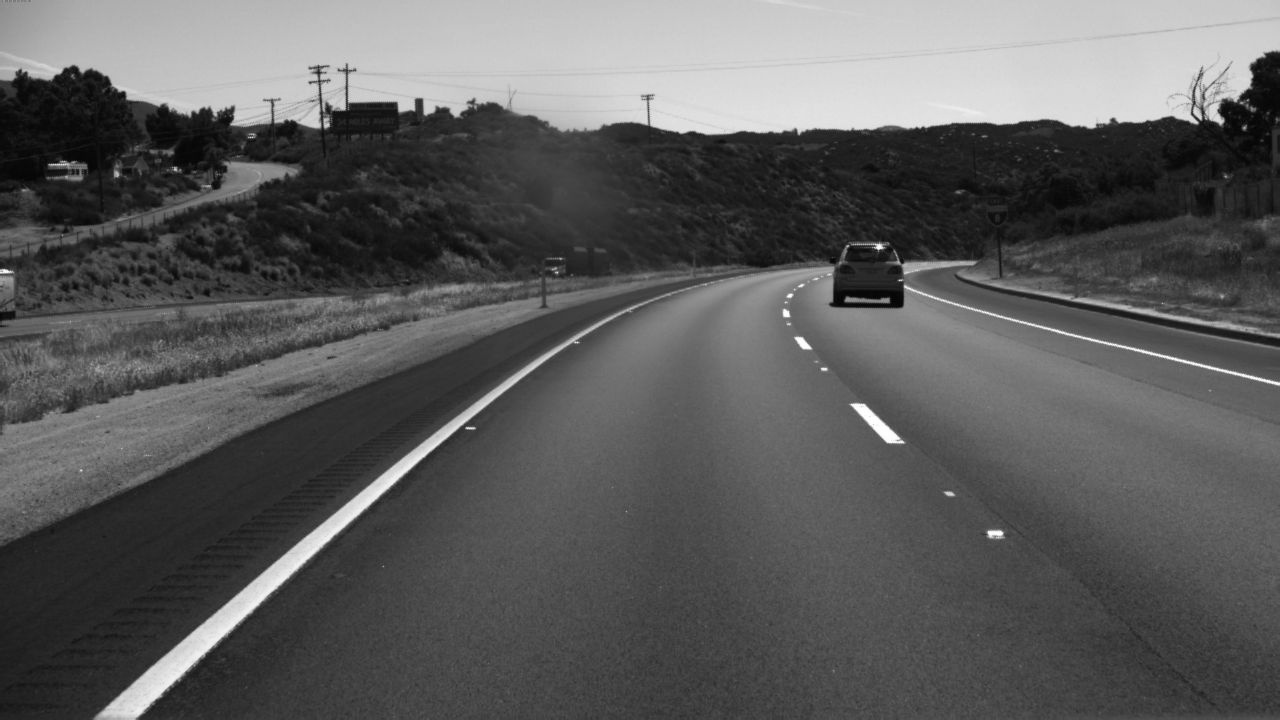

1


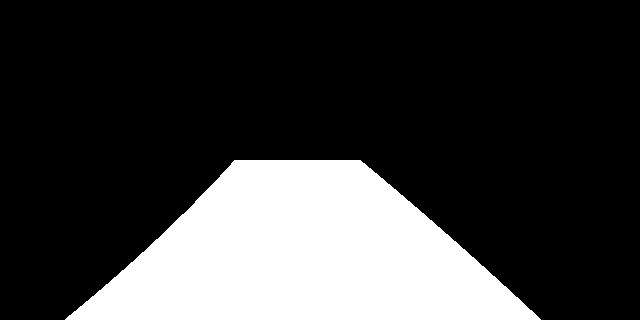

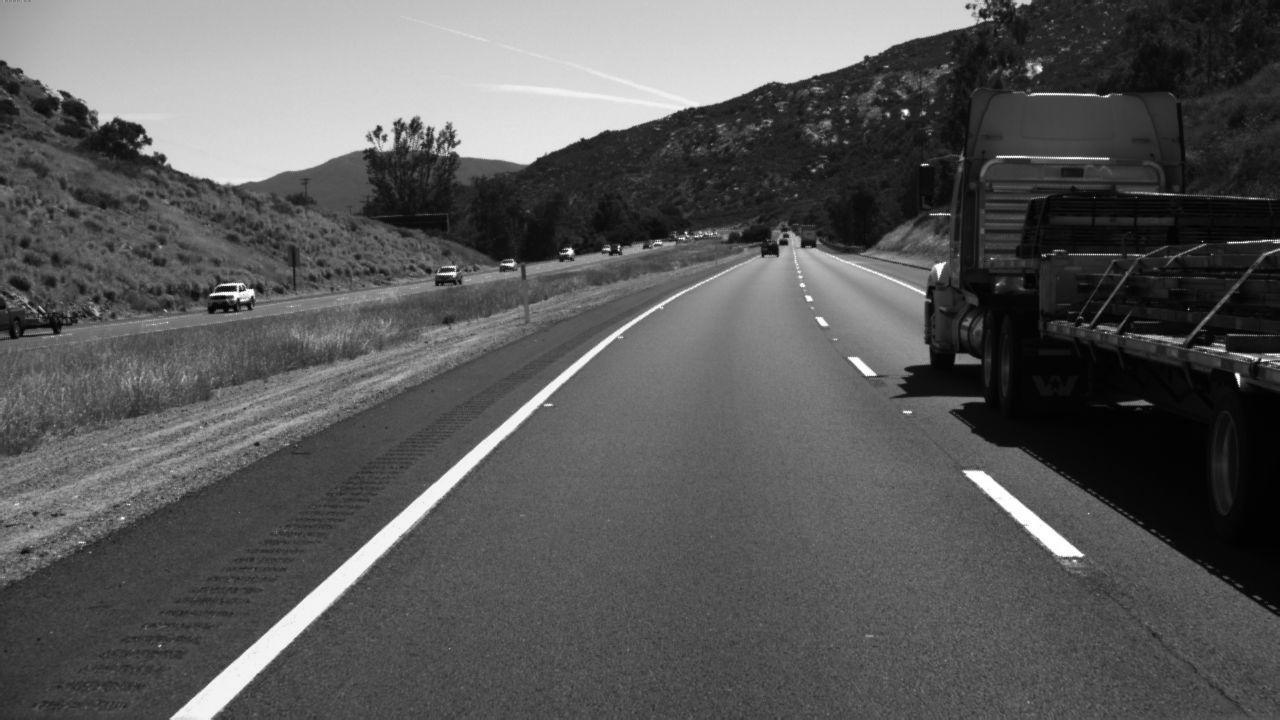

2


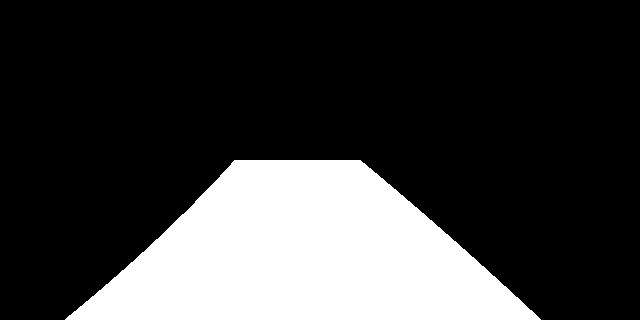

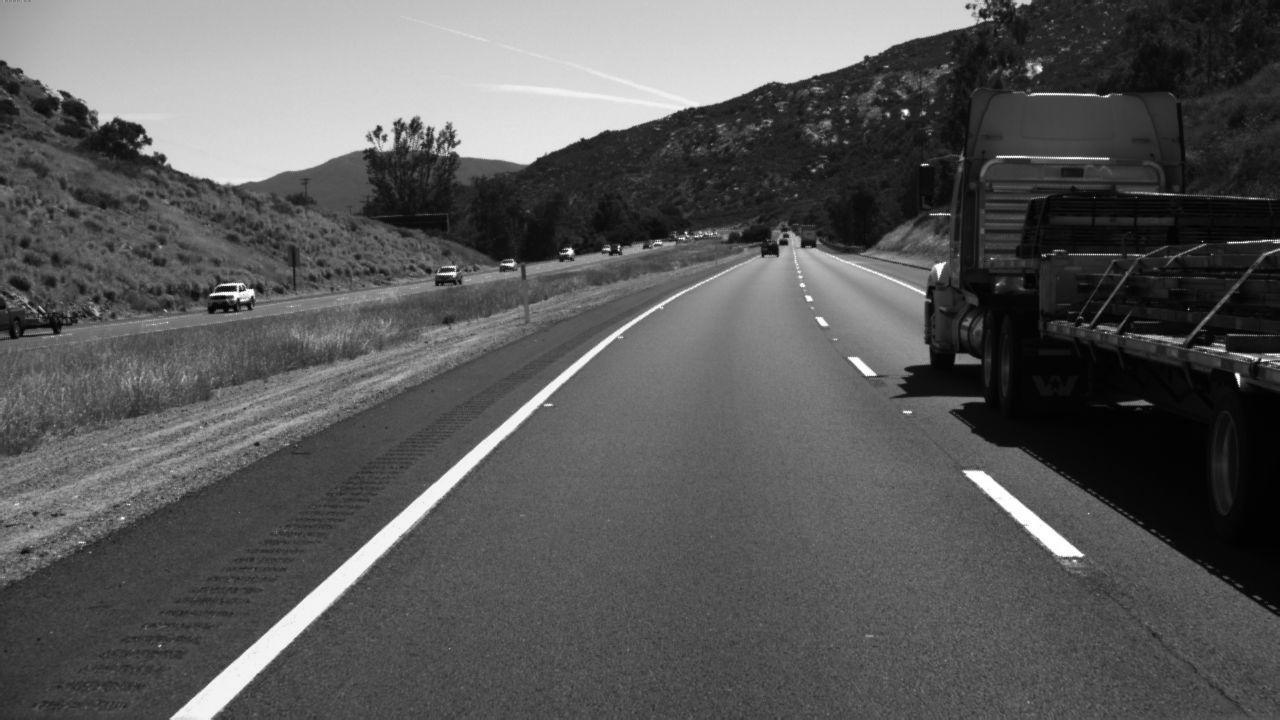

3


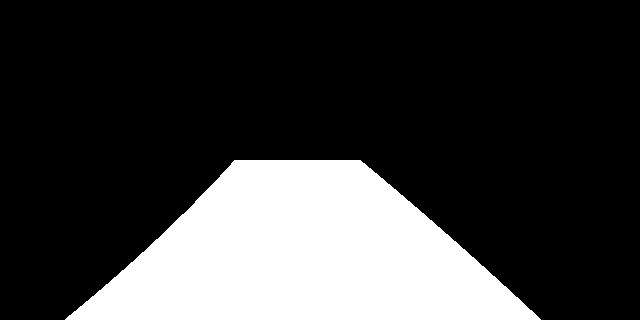

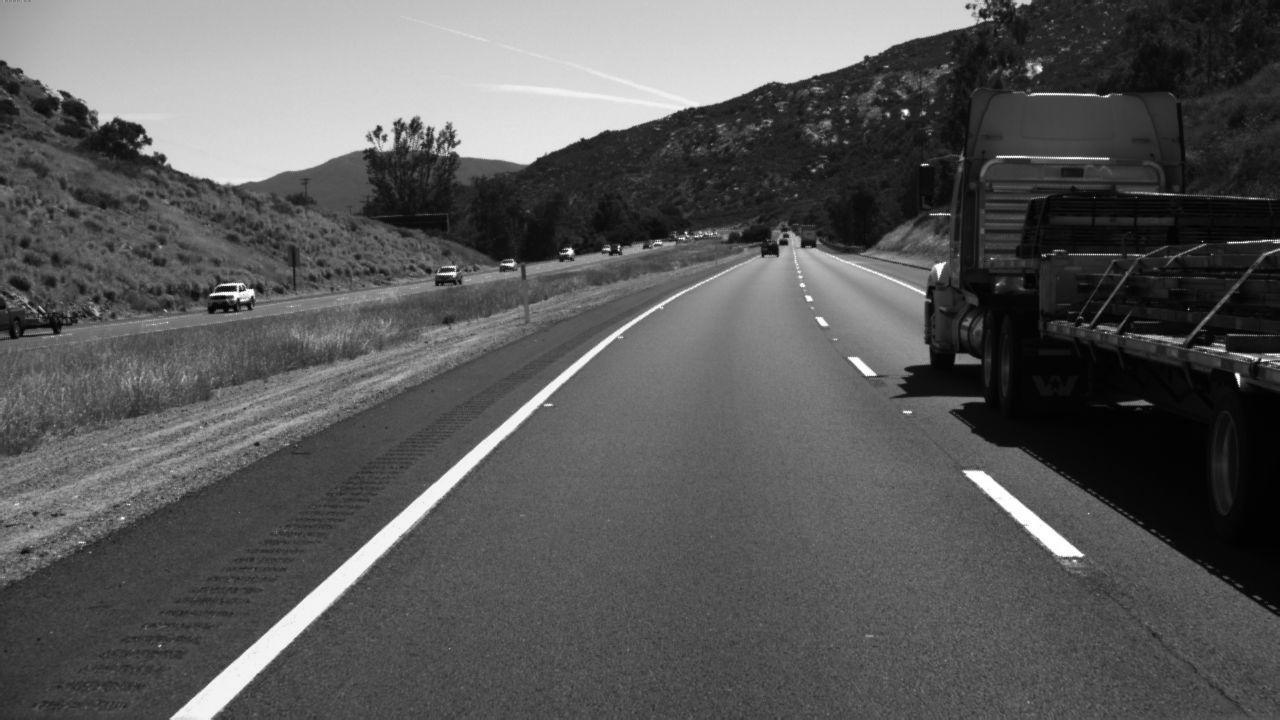

4


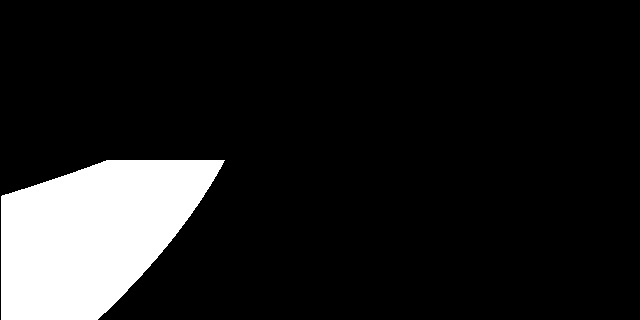

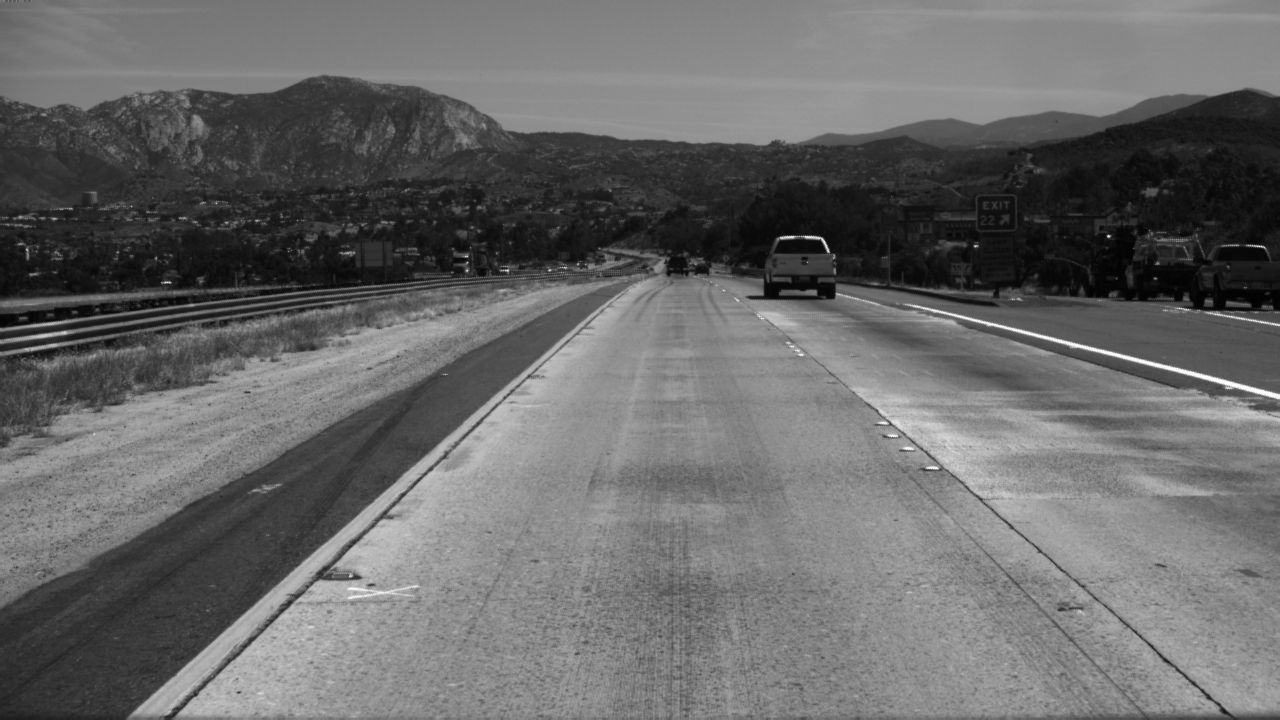

(320, 640)


In [21]:
import random
from google.colab.patches import cv2_imshow
for i in range(0,5):
  print(i)
  rand = random.randint(0, 4)
  im = orig[rand,:,:]
  img = y_segment[rand,:,:]
  #res = cv2.resize(img, (1280,720))
  #dst = cv2.addWeighted(res,1,im,1,0)

  cv2_imshow(img*255)
  cv2_imshow(im)
print(img.shape)

In [22]:
def unet():
    inputs = Input((h,w,1))
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer="rmsprop", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics =['accuracy'])
    #model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics =['accuracy'])
    return model

model = unet()
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 320, 640, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 320, 640, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 320, 640, 64  256        ['conv2d_24[0][0]']              
 ormalization)                  )                                                           

In [23]:
history = model.fit(x,y_segment, epochs=800, batch_size=1, verbose=1, shuffle=True)


#model.save('unet800_all2_fullsegment_binarycross_best_sofar.h5')

#model = keras.models.load_model('unet5_all1_binarycross.h5')

Epoch 1/800
4/4 [==============================] - 13s 330ms/step - loss: 0.8609 - accuracy: 0.5452
Epoch 2/800
4/4 [==============================] - 1s 305ms/step - loss: 0.8052 - accuracy: 0.6902
Epoch 3/800
4/4 [==============================] - 1s 305ms/step - loss: 0.7907 - accuracy: 0.7530
Epoch 4/800
4/4 [==============================] - 1s 305ms/step - loss: 0.7774 - accuracy: 0.7832
Epoch 5/800
4/4 [==============================] - 1s 306ms/step - loss: 0.7811 - accuracy: 0.7853
Epoch 6/800
4/4 [==============================] - 1s 307ms/step - loss: 0.7725 - accuracy: 0.7921
Epoch 7/800
4/4 [==============================] - 1s 307ms/step - loss: 0.7687 - accuracy: 0.7991
Epoch 8/800
4/4 [==============================] - 1s 307ms/step - loss: 0.7689 - accuracy: 0.7897
Epoch 9/800
4/4 [==============================] - 1s 309ms/step - loss: 0.7625 - accuracy: 0.8085
Epoch 10/800
4/4 [==============================] - 1s 308ms/step - loss: 0.7707 - accuracy: 0.7866
Epoch 11

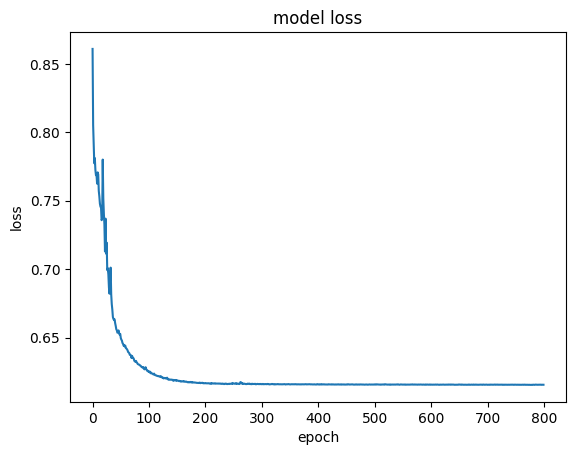

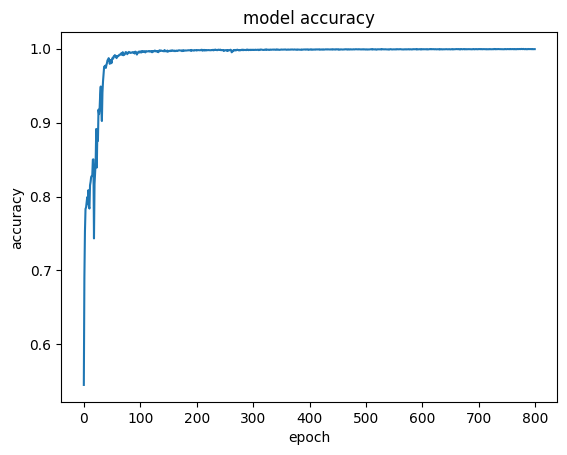

In [24]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
#x.shape
y_segment.shape

(4, 320, 640)

In [26]:
import random
from google.colab.patches import cv2_imshow

index = random.randint(0,len(train_img))
index=2
#index = train_img[index]
print(index)
test_img = x[index,:,:].reshape(1,h,w,1)
pred = model.predict(test_img).reshape(h,w)

#img = np.resize(pred, (h,w))
#resized = cv2.resize(img, (1280,720))
orr = orig[index,:,:]
#cv2_imshow(pred)
#cv2_imshow(orr)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


2
1/1 [==============================] - 1s 545ms/step


0.4316666666666667


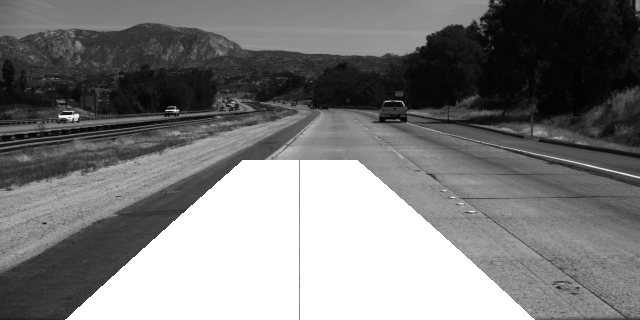

4.198215277777778


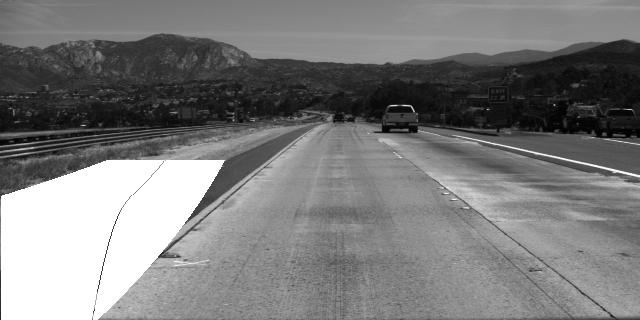

4.200913194444444


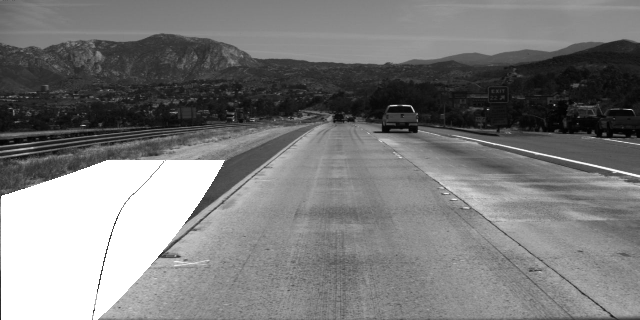

IndexError: ignored

In [30]:
import random
from google.colab.patches import cv2_imshow
for i in range(0,5):
  #print(i)
  rand = random.randint(0, len(x))
  im = orig[rand,:,:]
  #print(rand)
  res = y_segment[rand,:,:]
  im = cv2.resize(im, (640,320))
  total = 0
  count = 0
  a_t = 0
  a_c = 0
  for i in range(res.shape[0]):
    for j in range(res.shape[1]):
      if (res[i][j] == 1):
        total += j
        count += 1
    if(count>0):
      avg = int(total/count)
      res[i][avg] = 0
      a_t += avg
      a_c += 1
  raw = a_t/a_c
  #cv2.drawMarker(res,(250,200), (255), markerSize = 100, thickness =200)
  res = res*255
  if (raw < 320):
    dev = ((320 - raw) / 180 ) * 3.7
  elif(raw > 320):
    dev = ((raw - 320) / 180 ) * 3.7
#250,380
  print(dev)

  for i in range(res.shape[0]):
    for j in range(res.shape[1]):
      if(res[i][j] == 255):
        im[i][j] = 255
  #cv2_imshow(res)
  cv2_imshow(im)